In [1]:
from _shared import *

### Задача 4. Численный эксперимент

Мы рассмотрели несколько вариантов добавления эффекта.
Есть ли смысл думать о способе добавления эффекта при оценке вероятности ошибки II рода
или все способы дают одинаковый результат? Результаты могут быть разными.
Чтобы в этом убедиться, проведём численный эксперимент.

Допустим, в наш А/В-тест попадают все пользователи, совершавшие покупки до 28 марта.

 
1. __Целевая метрика__ — средняя выручка с клиента за время эксперимента.
1. Целевую метрику считаем __на неделе с 21 по 28 марта__.
1. __Уровень значимости__ — 0.05.
1. __Критерий__ — тест Стьюдента.
1. __Размер групп__ — 1000.
1. __Ожидаемый эффект__ — средняя выручка увеличится на 10%.

Нужно оценить вероятности ошибок II рода для трёх вариантов добавления эффекта:

1. Добавление константы ко всем значениям;
2. Умножение на константу всех значений;
3. Добавление константы к 2.5% значений.

Для решения используйте данные из файла `2022-04-01T12_df_sales.csv`.

В качестве ответа введите номера способов добавления эффекта в порядке увеличения оценки вероятности ошибки II рода. Например, если при добавлении константы ко всем значениям оценка вероятности ошибки минимальна, при добавлении константы к 2.5% значений максимальна, то ответ будет: 123.



In [2]:
target_metric = 'price' #mean per user.

begin_date = '2022-03-21'
end_date = '2022-03-28'

alpha = 0.05
criterion = stats.ttest_ind
group_size = 1000

mde = 0.10

filename = '2022-04-01T12_df_sales.csv'

In [3]:
df_src = read_from_database(filename, [1])

In [4]:
df_sales = get_data_subset(
    df=df_src,
    begin_date=begin_date,
    end_date=end_date,
    user_ids=None,
    columns=['date', 'price', 'user_id']
)
df_sales.head()

,date,price,user_id
164483,2022-03-21 10:00:26,1470,35093f
164484,2022-03-21 10:02:30,1440,d63544
164485,2022-03-21 10:05:15,540,62a836
164486,2022-03-21 10:06:45,600,1dcc25
164487,2022-03-21 10:06:45,630,e3644e


In [5]:
df_sales = (
    df_sales
    .groupby('user_id')
    ['price'].mean()
    .reset_index()
)
df_sales.head()

,user_id,price
0,000096,720.0
1,0000d4,720.0
2,0000de,660.0
3,0000e4,840.0
4,0001e2,1215.0


In [6]:
users = (
    get_data_subset(
        df=df_src,
        end_date=end_date,
        user_ids=None,
        columns=['user_id']
    ).value_counts()
    .reset_index()
    .loc[:, ['user_id']]
)

users

,user_id
0,a043f3
1,c7c2ca
2,4c6d72
3,7c1f01
4,184f85
...,...
98579,447621
98580,a8a705
98581,a8a740
98582,a8a7da


In [7]:
df_exp = (
    users
    .merge(
        right=df_sales,
        on='user_id',
        how='left'
    ).fillna(0.0)
)

df_exp['price'].value_counts()

0.0       72927
780.0      3469
720.0      2285
840.0      2138
600.0      1973
          ...  
1695.0        1
6870.0        1
5700.0        1
680.0         1
5460.0        1
Name: price, Length: 244, dtype: int64

In [8]:
rng = np.random.default_rng(132)
# (rng.random(size=1_000_000) < 0.025).mean()


def plot_pvalue_ecdf(pvalues, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    if title:
        plt.suptitle(title)

    sns.histplot(pvalues, ax=ax1, bins=20, stat='density')
    ax1.plot([0,1], [1,1], 'k--')
    ax1.set(xlabel='p-value', ylabel='Density')

    sns.ecdfplot(pvalues, ax=ax2)
    ax2.plot([0,1], [0,1], 'k--')
    ax2.set(xlabel='p-value', ylabel='Probability')
    ax2.grid()


# def get_error_rate(df, n, cols):
#     pvalue_list = []
#     users = df['user_id'].unique()
    
#     for _ in range(n):
#         rng.shuffle(users)
#         group_a, group_b = users[group_size:], users[:group_size]
        
#         sales_a = df.loc[df['user_id'].isin(group_a), cols[0]]
#         sales_b = df.loc[df['user_id'].isin(group_b), cols[1]]

#         pvalue_list.append(stats.ttest_ind(sales_a, sales_b).pvalue)
        
#     return np.array(pvalue_list)


mde_price = df_exp['price'].mean() * mde
mde_price_rnd = mde_price * group_size / (group_size * 0.025) #Focus mde_price in the few affected users (very not obvious).

def get_error_rates(df, n, error_rates=None):
    error_rates = {
        'price': [],
        '1_price_add': [],
        '2_price_mul': [],
        '3_price_rnd': []
    }

    users = df['user_id'].unique()
    
    for _ in range(n):
        users_sub = np.random.choice(users, group_size * 2, replace=False)
        group_a, group_b = users_sub[:group_size], users_sub[group_size:]
        
        df_sub = (
            df
            .loc[
                df['user_id'].isin(users_sub),
                ['user_id', 'price']
            ].copy()
        )
        
        sales_a = df_sub.loc[df_sub['user_id'].isin(group_a), 'price']
        sales_b = df_sub.loc[df_sub['user_id'].isin(group_b), ['price']]
            
        sales_b['1_price_add'] = sales_b['price'] + mde_price
        sales_b['2_price_mul'] = sales_b['price'] * (1.0 + mde)
        sales_b['3_price_rnd'] = sales_b['price'] + (rng.random(size=sales_b.shape[0]) < 0.025) * mde_price_rnd

        for k in error_rates.keys():
            error_rates[k].append(stats.ttest_ind(sales_a, sales_b[k]).pvalue)
        
    return pd.DataFrame(error_rates)

In [9]:
error_rates = get_error_rates(df_exp, 30_000)
error_rates.head()

,price,1_price_add,2_price_mul,3_price_rnd
0,0.268749,0.995398,0.933384,0.926923
1,0.731808,0.511401,0.491635,0.799286
2,0.285113,0.031438,0.037366,0.009371
3,0.915028,0.231896,0.249669,0.163952
4,0.597912,0.105169,0.122264,0.088998


Type II rates:
price - 0.950
1_price_add - 0.809
2_price_mul - 0.825
3_price_rnd - 0.816


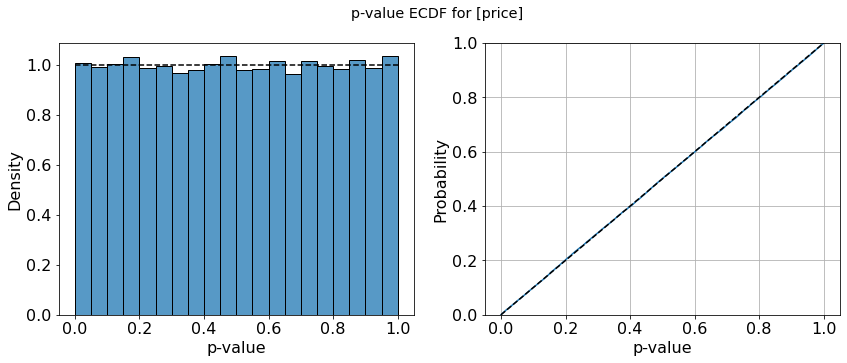

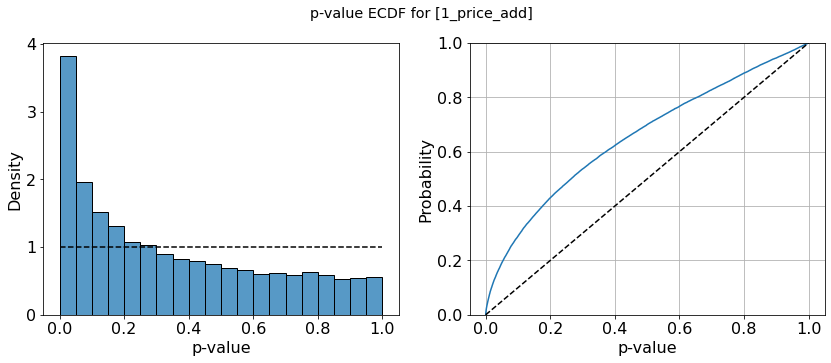

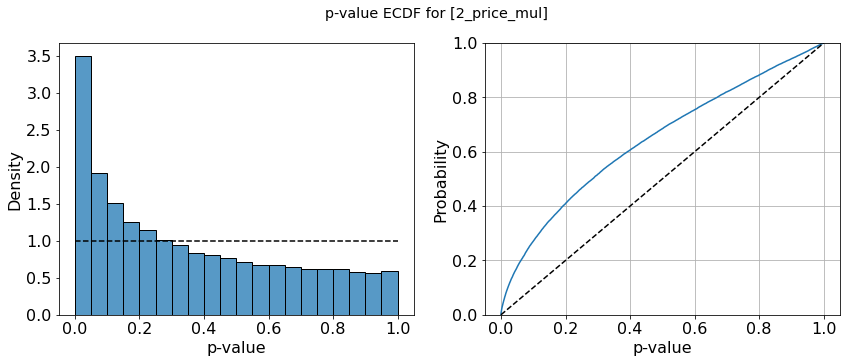

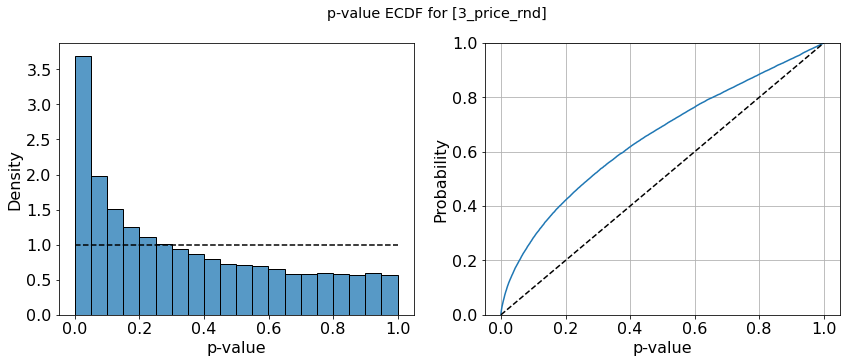

In [10]:
print('Type II rates:')
for col in error_rates.columns[:4]:
    print('{} - {:.3f}'.format(col, (error_rates[col] > alpha).mean()))
    plot_pvalue_ecdf(error_rates[col], 'p-value ECDF for [{}]'.format(col))

In [11]:
(error_rates > alpha).mean().sort_values()
#Answer is (finally) "132".

1_price_add    0.808733
3_price_rnd    0.815500
2_price_mul    0.825000
price          0.949500
dtype: float64

In [12]:
# Solution
import os
from datetime import datetime
import numpy as np
import pandas as pd
from scipy import stats
# from tqdm.notebook import tqdm

URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

df_sales = read_database('2022-04-01T12_df_sales.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'])

begin_date = datetime(2022, 3, 21)
end_date = datetime(2022, 3, 28)
df_users = df_sales[df_sales['date'] < end_date][['user_id']].drop_duplicates()
df_metrics = (
    df_sales
    [(df_sales['date'] >= begin_date) & (df_sales['date'] < end_date)]
    .groupby('user_id')[['price']].sum()
    .reset_index()  
)
df = pd.merge(df_users, df_metrics, on='user_id', how='left').fillna(0)

alpha = 0.05
sample_size = 1000
effect = 0.1

pvalues = {'one': [], 'two': [], 'three': []}
values = df['price'].values
mean_ = values.mean()

# for _ in tqdm(range(30000)):
for _ in range(30000):
    # выбираем случайные группы
    a, b = np.random.choice(values, (2, sample_size,), False)
    # добавляем эффект тремя способами
    b_one = b + mean_ * effect
    b_two = b * (1 + effect)
    indexes = np.random.choice(np.arange(sample_size), int(sample_size * 0.025), False)
    add_value = effect * mean_ * sample_size / len(indexes)
    mask = np.zeros(sample_size)
    mask[indexes] += 1
    b_three = b + mask * add_value
    # считаем и сохраняем p-value
    for b_, key in ((b_one, 'one',), (b_two, 'two',), (b_three, 'three',),):
        pvalues[key].append(stats.ttest_ind(a, b_).pvalue)

# считаем точечные оценки вероятностей ошибки II рода
for key, v in pvalues.items():
    errors = (np.array(v) > alpha).astype(int)
    part_errors = np.mean(errors)
    print(f'{key}: part errors = {part_errors:0.4f}')

# проверим, что отличия статистически значимые
print(stats.ttest_ind(pvalues['one'], pvalues['three']).pvalue)
print(stats.ttest_ind(pvalues['two'], pvalues['three']).pvalue)
#Answer is "132".

one: part errors = 0.8117
two: part errors = 0.8287
three: part errors = 0.8243
0.006953845920687858
0.020847332229961095


### Задача 5. Функция оценки вероятности ошибок I/II рода

In [13]:
import numpy as np
import pandas as pd
from scipy import stats


def estimate_errors(group_generator, effect_add_type, effect, alpha):
    """Оцениваем вероятности ошибок I и II рода.

    :param group_generator: генератор значений метрик для двух групп.
    :param effect_add_type (str): способ добавления эффекта для группы B.
        - 'all_const' - увеличить всем значениям в группе B на константу (b_metric_values.mean() * effect / 100).
        - 'all_percent' - увеличить всем значениям в группе B в (1 + effect / 100) раз.
    :param effect (float): размер эффекта в процентах.
        Пример, effect=3 означает, что ожидаем увеличение среднего на 3%.
    :param alpha (float): уровень значимости.
    :return pvalues_aa (list[float]), pvalues_ab (list[float]), first_type_error (float), second_type_error (float):
        - pvalues_aa, pvalues_ab - списки со значениями pvalue
        - first_type_error, second_type_error - оценки вероятностей ошибок I и II рода.
    """
    pvalues_aa, pvalues_ab = [], []
    first_type_error, second_type_error = None, None
    
    for metrics_a_values, metrics_b_values in group_generator:
        pvalues_aa.append(stats.ttest_ind(metrics_a_values, metrics_b_values).pvalue)
        
        if effect_add_type == 'all_const':
            metrics_b_values += metrics_b_values.mean() * effect / 100
        elif effect_add_type == 'all_percent':
            metrics_b_values *= (1 + effect / 100.0)
            
        pvalues_ab.append(stats.ttest_ind(metrics_a_values, metrics_b_values).pvalue)
    
    first_type_error = (np.array(pvalues_aa) < alpha).mean() #Positive in absence of effect.
    second_type_error = (np.array(pvalues_ab) >= alpha).mean() #Negative in presence of effect.
    
    return (pvalues_aa, pvalues_ab, first_type_error, second_type_error)


def create_group_generator(metrics, sample_size, n_iter):
    """Генератор случайных групп.

    :param metrics (pd.DataFame): таблица с метриками, columns=['user_id', 'metric'].
    :param sample_size (int): размер групп (количество пользователей в группе).
    :param n_iter (int): количество итераций генерирования случайных групп.
    :return (np.array, np.array): два массива со значениями метрик в группах.
    """
    user_ids = metrics['user_id'].unique()
    for _ in range(n_iter):
        a_user_ids, b_user_ids = np.random.choice(user_ids, (2, sample_size), False)
        a_metric_values = metrics.loc[metrics['user_id'].isin(a_user_ids), 'metric'].values
        b_metric_values = metrics.loc[metrics['user_id'].isin(b_user_ids), 'metric'].values
        yield a_metric_values, b_metric_values


metrics = pd.DataFrame({'user_id': [1, 2, 3, 4], 'metric': [5, 6, 8, 9.1] })
sample_size = 2
n_iter = 3
group_generator = create_group_generator(metrics, sample_size, n_iter)

for metrics_a_group, metrics_b_group in group_generator:
    print(metrics_a_group, metrics_b_group)
# >>> [8.  9.1] [5. 6.]
# >>> [5.  9.1] [6. 8.]
# >>> [5. 6.] [8.  9.1]

def print_result(**kwargs):
    """Prints keyword agruments with their names (thus, requires named argument call)."""
    for (k, v) in kwargs.items():
        print('{} = {}'.format(k, v))



[5. 6.] [8.  9.1]
[6. 8.] [5.  9.1]
[8.  9.1] [5. 6.]


In [14]:
sample_size, n_iter, effect, alpha = 100, 10, 6, 0.05

group_generator = (
    (np.arange(sample_size, dtype=float), np.arange(sample_size, dtype=float) + x,)
    for x in range(n_iter)
)
effect_add_type = 'all_const'
pvalues_aa, pvalues_ab, first_type_error, second_type_error = estimate_errors(
    group_generator, effect_add_type, effect, alpha
)
# pvalues_aa = [1.0, 0.808, 0.626, 0.466, 0.331, 0.224, 0.145, 0.09, 0.053, 0.029]
# pvalues_ab = [0.47, 0.327, 0.216, 0.135, 0.08, 0.045, 0.024, 0.012, 0.006, 0.003]
# first_type_error = 0.1
# second_type_error = 0.5
print_result(
    pvalues_aa=np.array(pvalues_aa).round(3),
    pvalues_ab=np.array(pvalues_ab).round(3),
    first_type_error=first_type_error,
    second_type_error=second_type_error
)

pvalues_aa = [1.    0.808 0.626 0.466 0.331 0.224 0.145 0.09  0.053 0.029]
pvalues_ab = [0.47  0.327 0.216 0.135 0.08  0.045 0.024 0.012 0.006 0.003]
first_type_error = 0.1
second_type_error = 0.5


In [15]:
group_generator = (
    (np.arange(sample_size, dtype=float), np.arange(sample_size, dtype=float) + x,)
    for x in range(n_iter)
)
effect_add_type = 'all_percent'
pvalues_aa, pvalues_ab, first_type_error, second_type_error = estimate_errors(
    group_generator, effect_add_type, effect, alpha
)
# pvalues_aa = [1.0, 0.808, 0.626, 0.466, 0.331, 0.224, 0.145, 0.09, 0.053, 0.029]
# pvalues_ab = [0.483, 0.342, 0.23, 0.147, 0.09, 0.052, 0.028, 0.015, 0.007, 0.003]
# first_type_error = 0.1
# second_type_error = 0.6
print_result(
    pvalues_aa=np.array(pvalues_aa).round(3),
    pvalues_ab=np.array(pvalues_ab).round(3),
    first_type_error=first_type_error,
    second_type_error=second_type_error
)

pvalues_aa = [1.    0.808 0.626 0.466 0.331 0.224 0.145 0.09  0.053 0.029]
pvalues_ab = [0.483 0.342 0.23  0.147 0.09  0.052 0.028 0.015 0.007 0.003]
first_type_error = 0.1
second_type_error = 0.6


In [16]:
#Solution

import numpy as np
from scipy import stats


def get_ttest_pvalue(metrics_a_group, metrics_b_group):
    _, pvalue = stats.ttest_ind(metrics_a_group, metrics_b_group)
    return pvalue

def estimate_errors(group_generator, effect_add_type, effect, alpha):
    pvalues_aa = []
    pvalues_ab = []
    for a_metric_values, b_metric_values in group_generator:
        pvalues_aa.append(get_ttest_pvalue(a_metric_values, b_metric_values))
        b_metric_values_with_effect = b_metric_values.copy()
        if effect_add_type == 'all_percent':
            b_metric_values_with_effect *= 1 + effect / 100
        elif effect_add_type == 'all_const':
            b_metric_values_with_effect += b_metric_values_with_effect.mean() * effect / 100
        pvalues_ab.append(get_ttest_pvalue(a_metric_values, b_metric_values_with_effect))
    first_type_error = np.mean(np.array(pvalues_aa) < alpha)
    second_type_error = np.mean(np.array(pvalues_ab) >= alpha)
    return pvalues_aa, pvalues_ab, first_type_error, second_type_error